In [1]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyhrv
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)



from tqdm.notebook import tqdm


# 원래 함수인데 지우지 말것
def processECG(data): 
    
    
    ecg_signal = data['ecgArray']
    
    try:
        _, info = nk.ecg_process(ecg_signal, sampling_rate = 200)
        rpeaks = info["ECG_R_Peaks"]
        hrv_indices_time = nk.hrv_time(rpeaks, sampling_rate = 200)
        meannn = hrv_indices_time["HRV_MeanNN"][0]
        pnn50 = hrv_indices_time["HRV_pNN50"][0]
        test_HRV = meannn, pnn50
    except:
        test_HRV = 'None', 'None'
    
    sampling_rate = 200  
    method = 'neurokit'
    
    try:
        ecg_signal = nk.signal_sanitize(ecg_signal)
        ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate = sampling_rate, method = method)
    except Exception as e:
        return { "HR": 'None', 'ECG_Processed' : 'None', 'ECG_MeanNN' : test_HRV[0], 'ECG_pNN50' : test_HRV[1], 
                'Short_Message' : 'ECG_Filtering_Error'}
    
    # Detect R-peaks
    try:
        _, info = nk.ecg_peaks(
            ecg_cleaned = ecg_cleaned,
            sampling_rate = sampling_rate,
            method = method,
            correct_artifacts = True,
        )
    except Exception as e:
        return { "HR": 'None', 'ECG_Processed' : list(ecg_cleaned), 'ECG_MeanNN' : test_HRV[0], 'ECG_pNN50' : test_HRV[1], 
                'Short_Message' : 'ECG_Detecting_Peaks_Error'}
    
    # Calculate Heart Rate
    try:    
        rate = nk.signal_rate(
            info, sampling_rate=sampling_rate, desired_length=len(ecg_cleaned)
        )
        rate = rate.mean()
        
        rate = round(rate, 1)
        
    except Exception as e:
        return { "HR": 'None', 'ECG_Processed' : list(ecg_cleaned), 'ECG_MeanNN' : test_HRV[0], 'ECG_pNN50' : test_HRV[1], 
                'Short_Message' : 'ECG_Computing_HeartRate_Error'}
    
    if np.isnan(rate):
        return { "HR": 'None', 'ECG_Processed' : list(ecg_cleaned), 'ECG_MeanNN' : test_HRV[0], 'ECG_pNN50' : test_HRV[1], 
                'Short_Message' : 'ECG_Computing_HeartRate_Error'}
        
    return { "HR": rate, 'ECG_Processed' : list(ecg_cleaned), 'ECG_MeanNN' : test_HRV[0], 'ECG_pNN50' : test_HRV[1],
            'Short_Message' : 'SUCCESS'}

In [2]:
dataset = pd.read_json('20240610.json')
dataset.columns, len(dataset)

(Index(['_id', 'userId', 'createdAt', 'data', 'userCancelledAt',
        'userRemovedAt'],
       dtype='object'),
 1581)

In [3]:
def get_signals(row):
    try:
        data = row['data']
        ecg = data['ecg']['ecgArray']
        irppg = data['ppg']['irArray']
        redppg = data['ppg']['redArray']
        result = {
            'ecg' : ecg,
            'irppg' : irppg,
            'redppg' : redppg 
        }
    except:
        result = {
            'ecg' : None,
            'irppg' : None,
            'redppg' : None 
        }
    return pd.Series(result)

signals = dataset.apply(get_signals, axis = 1).dropna()
signals['ecg_std'] = signals.apply(lambda x : np.std(x['ecg']), axis = 1)
signals.drop(signals[signals['ecg_std'] < 10].index, inplace = True)
signals['ECG'] = signals.apply(lambda x : {'ecgArray' : x[0]}, axis = 1)
signals

,ecg,irppg,redppg,ecg_std,ECG
2,"[32767, 32767, 32767, 32767, 32767, 32767, 327...","[4454, 4456, 4458, 4453, 4455, 4454, 4450, 445...","[17263, 17249, 17255, 17274, 17241, 17233, 172...",2961.478529,"{'ecgArray': [32767, 32767, 32767, 32767, 3276..."
3,"[31675, 31498, 31278, 31641, 31688, 31013, 312...","[10453, 10456, 10456, 10472, 10469, 10491, 104...","[21951, 21945, 21906, 22091, 21890, 22010, 220...",2086.989928,"{'ecgArray': [31675, 31498, 31278, 31641, 3168..."
4,"[19599, 19582, 20035, 19607, 19251, 19648, 196...","[14590, 14593, 14608, 14619, 14637, 14657, 146...","[26419, 26494, 26433, 26489, 26598, 26422, 265...",1010.400505,"{'ecgArray': [19599, 19582, 20035, 19607, 1925..."
8,"[17195, 17801, 17948, 17230, 17609, 17976, 171...","[19959, 19801, 19614, 19448, 19344, 19246, 191...","[-28463, -28561, -28958, -29200, -29336, -2938...",1893.426719,"{'ecgArray': [17195, 17801, 17948, 17230, 1760..."
9,"[6220, 5821, 6170, 6561, 6059, 6079, 6562, 627...","[9851, 9846, 9847, 9834, 9837, 9845, 9857, 985...","[27113, 27000, 27003, 27175, 27285, 27033, 270...",1082.868275,"{'ecgArray': [6220, 5821, 6170, 6561, 6059, 60..."
...,...,...,...,...,...
1567,"[-722, -682, -756, -796, -743, -741, -789, -77...","[-31537, -31535, -31544, -31561, -31550, -3154...","[-24173, -24171, -24155, -24317, -24338, -2420...",239.000731,"{'ecgArray': [-722, -682, -756, -796, -743, -7..."
1568,"[-149, -128, -94, -134, -153, -115, -114, -154...","[12619, 12634, 12630, 12644, 12638, 12645, 126...","[20802, 20953, 21001, 21008, 21002, 21000, 209...",118.265840,"{'ecgArray': [-149, -128, -94, -134, -153, -11..."
1572,"[14105, 14570, 14973, 14599, 14480, 14888, 146...","[17984, 17966, 17967, 17976, 17965, 17967, 179...","[26419, 26541, 26555, 26560, 26577, 26604, 262...",1651.268366,"{'ecgArray': [14105, 14570, 14973, 14599, 1448..."
1577,"[6982, 7221, 7596, 7630, 7688, 7647, 7646, 769...","[16566, 16558, 16560, 16568, 16564, 16568, 165...","[-30945, -29727, -29763, -29647, -29752, -2963...",2309.877377,"{'ecgArray': [6982, 7221, 7596, 7630, 7688, 76..."


In [4]:
processECG(signals['ECG'].iloc[1])['ECG_pNN50']

22.22222222222222

In [5]:
from New_processECG import *

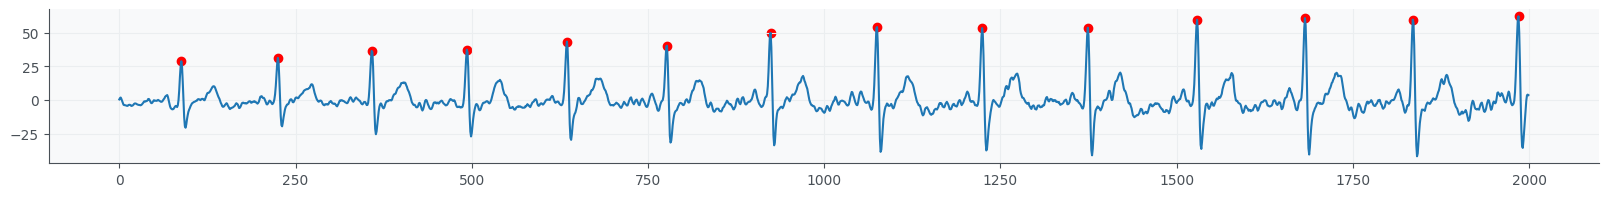

In [9]:
test = signals['ECG'].iloc[120]['ecgArray']
filtered = nk_filter(test)['filtered']
peaks = nk_rpeaks(filtered)['rpeaks']



plt.figure(figsize = (20, 2))
plt.plot(filtered)
plt.scatter(peaks, filtered[peaks], color = 'red')

## fiu  

In [8]:
from New_processECG import processECG as new_processECG

In [19]:
results = list()
for i in tqdm(signals['ECG']):
    results.append(new_processECG(i))
    
results = pd.DataFrame(results).dropna()
results[results['Short_Message'] == 'SUCCESS']
results

  0%|          | 0/877 [00:00<?, ?it/s]

,HR,ECG_Processed,RMSSD,SDNN,SD1_SD2,LF_HF,Short_Message
1,60.705587,"[360.25868702885754, 303.9873370722016, 230.62...",43.120471,34.044497,1.116797,0.284719,SUCCESS
2,74.224898,"[275.7923372560979, 321.4398634388805, 371.802...",84.129530,82.409883,0.605525,0.641091,SUCCESS
3,81.897854,"[1112.0166327090978, 1328.1017291658854, 1515....",200.106222,160.296600,0.823051,0.178372,SUCCESS
4,61.387011,"[-187.67209480834777, -212.47769839375763, -21...",62.990929,47.767106,0.907320,1.080425,SUCCESS
5,62.729787,"[48.96356327263487, 193.33972297308134, 301.58...",34.595881,27.738862,0.800916,1.224819,SUCCESS
...,...,...,...,...,...,...,...
872,85.222598,"[19.768753299042, 10.572634882068439, -0.18463...",210.376646,165.989457,0.820556,0.126617,SUCCESS
873,73.850129,"[1.70449051127747, 12.582909584086895, 22.0242...",16.807736,25.226249,0.363388,0.765641,SUCCESS
874,72.485473,"[175.81673393128904, 426.8836170014562, 637.92...",25.927249,49.690710,0.261387,1.579519,SUCCESS
875,50.681138,"[-325.7751616465756, -109.4528603762531, 78.02...",35.881750,23.704530,1.219919,0.165455,SUCCESS


Text(0.5, 1.0, 'n : 728 | 78.836±8.07')

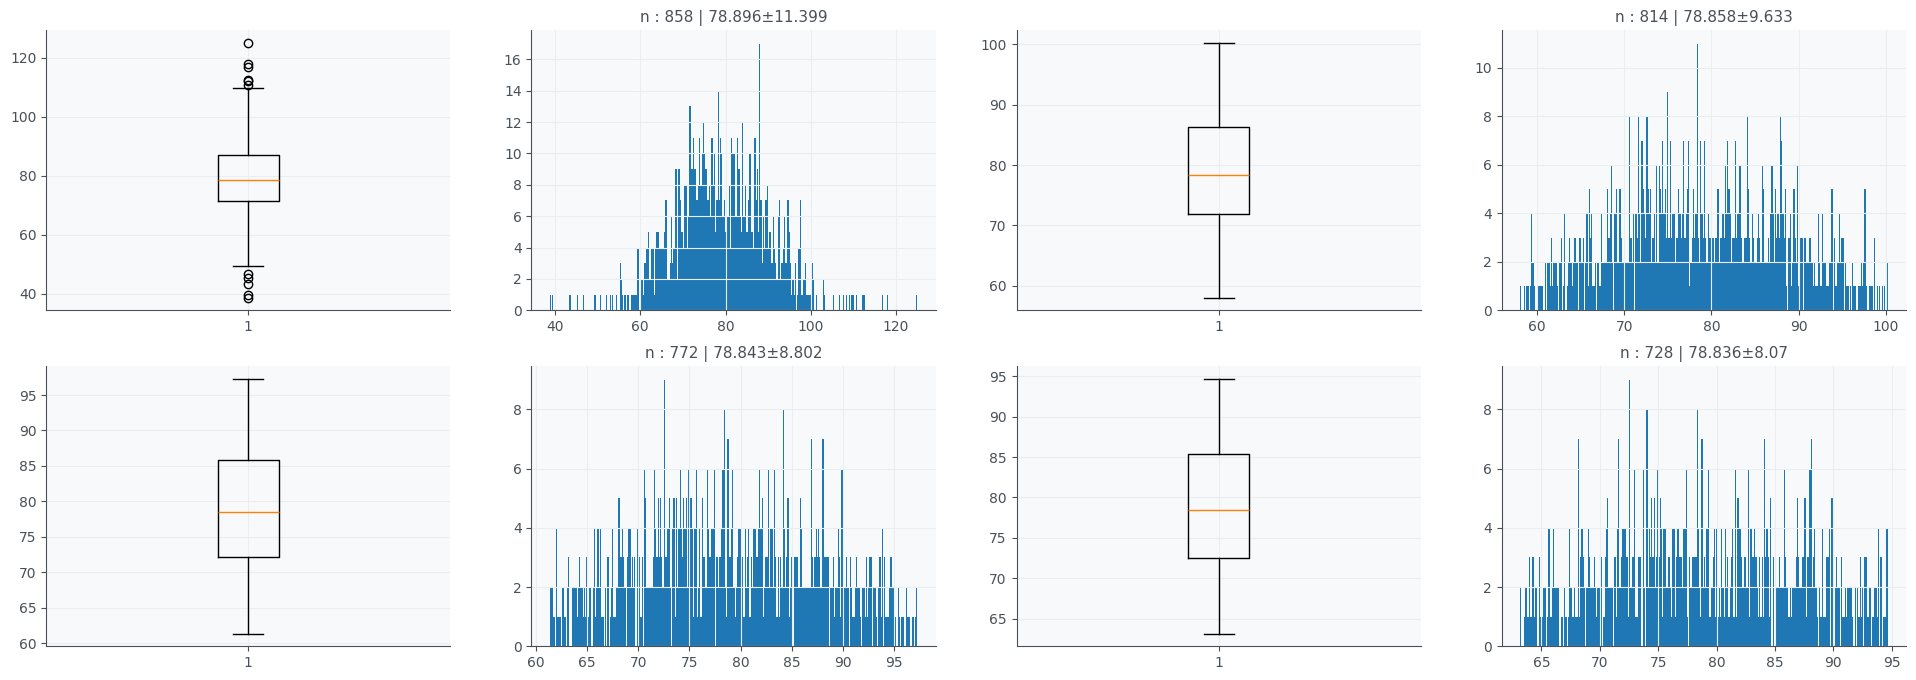

In [103]:



variable = 'HR'
data = results[[variable]].astype(float)

plt.figure(figsize = (24, 8))
plt.subplot(2, 4, 1)
plt.boxplot(data)
plt.subplot(2, 4, 2)
_ = plt.hist(data, bins = 300)
plt.title(f'n : {len(data)} | {round(data.mean().item(), 3)}±{round(data.std().item(), 3)}',)

cut = data[(data[variable] < data.quantile(0.975)[variable]) & (data[variable] > data.quantile(0.025)[variable])]
plt.subplot(2, 4, 3)
plt.boxplot(cut)
plt.subplot(2, 4, 4)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[(data[variable] < data.quantile(0.95)[variable]) & (data[variable] > data.quantile(0.05)[variable])]
plt.subplot(2, 4, 5)
plt.boxplot(cut)
plt.subplot(2, 4, 6)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[(data[variable] < data.quantile(0.925)[variable]) & (data[variable] > data.quantile(0.075)[variable])]
plt.subplot(2, 4, 7)
plt.boxplot(cut)
plt.subplot(2, 4, 8)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)


Text(0.5, 1.0, 'n : 600 | 19.199±9.65')

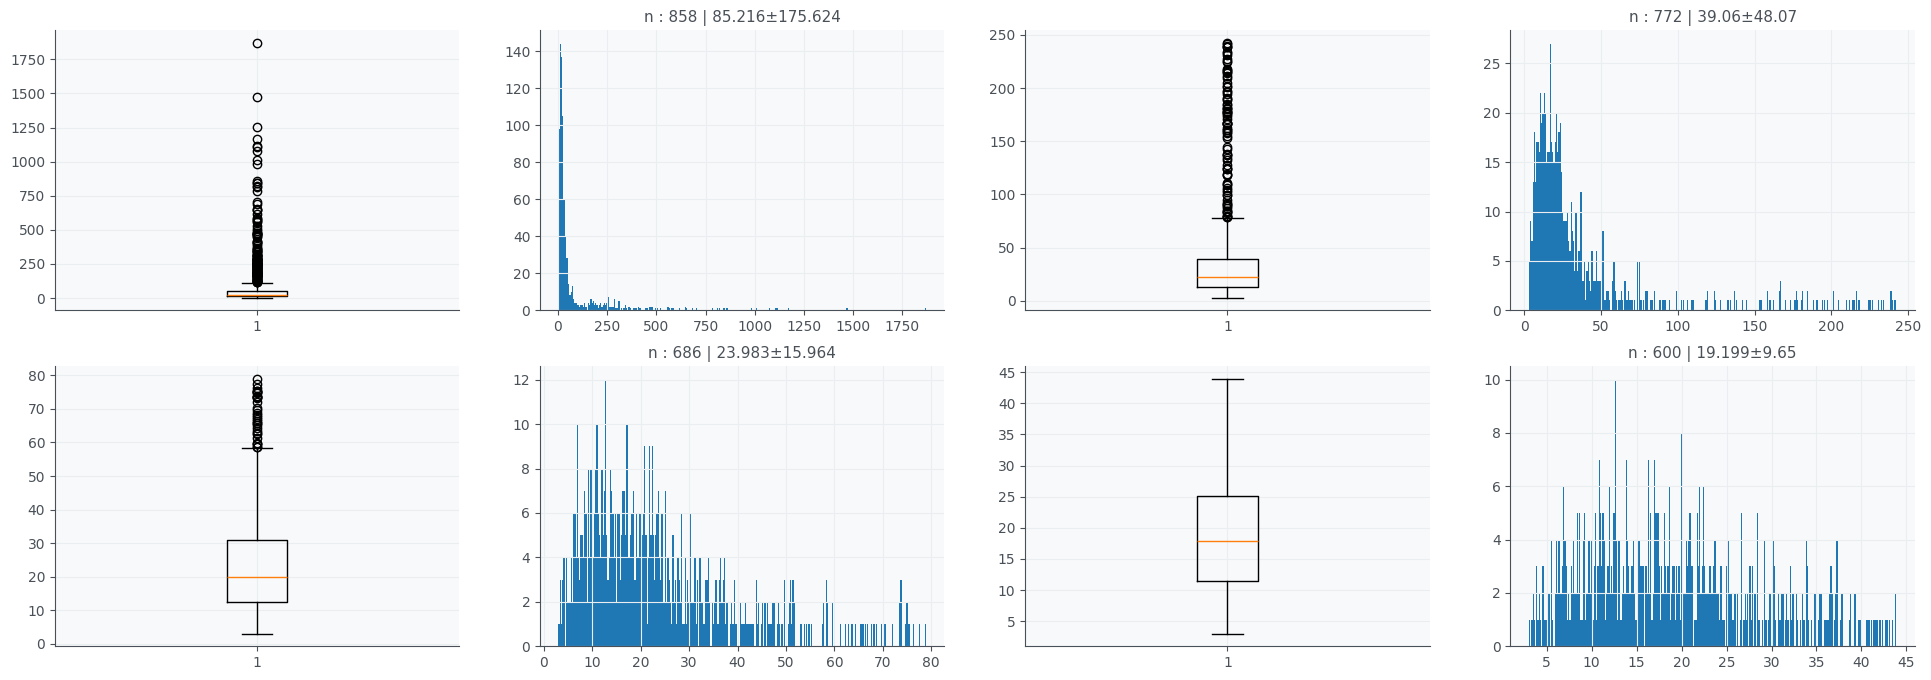

In [104]:
variable = 'SDNN'
data = results[[variable]]

plt.figure(figsize = (24, 8))
plt.subplot(2, 4, 1)
plt.boxplot(data)
plt.subplot(2, 4, 2)
_ = plt.hist(data, bins = 300)
plt.title(f'n : {len(data)} | {round(data.mean().item(), 3)}±{round(data.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.90)[variable]]
plt.subplot(2, 4, 3)
plt.boxplot(cut)
plt.subplot(2, 4, 4)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.80)[variable]]
plt.subplot(2, 4, 5)
plt.boxplot(cut)
plt.subplot(2, 4, 6)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.70)[variable]]
plt.subplot(2, 4, 7)
plt.boxplot(cut)
plt.subplot(2, 4, 8)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)


Text(0.5, 1.0, 'n : 600 | 0.565±0.193')

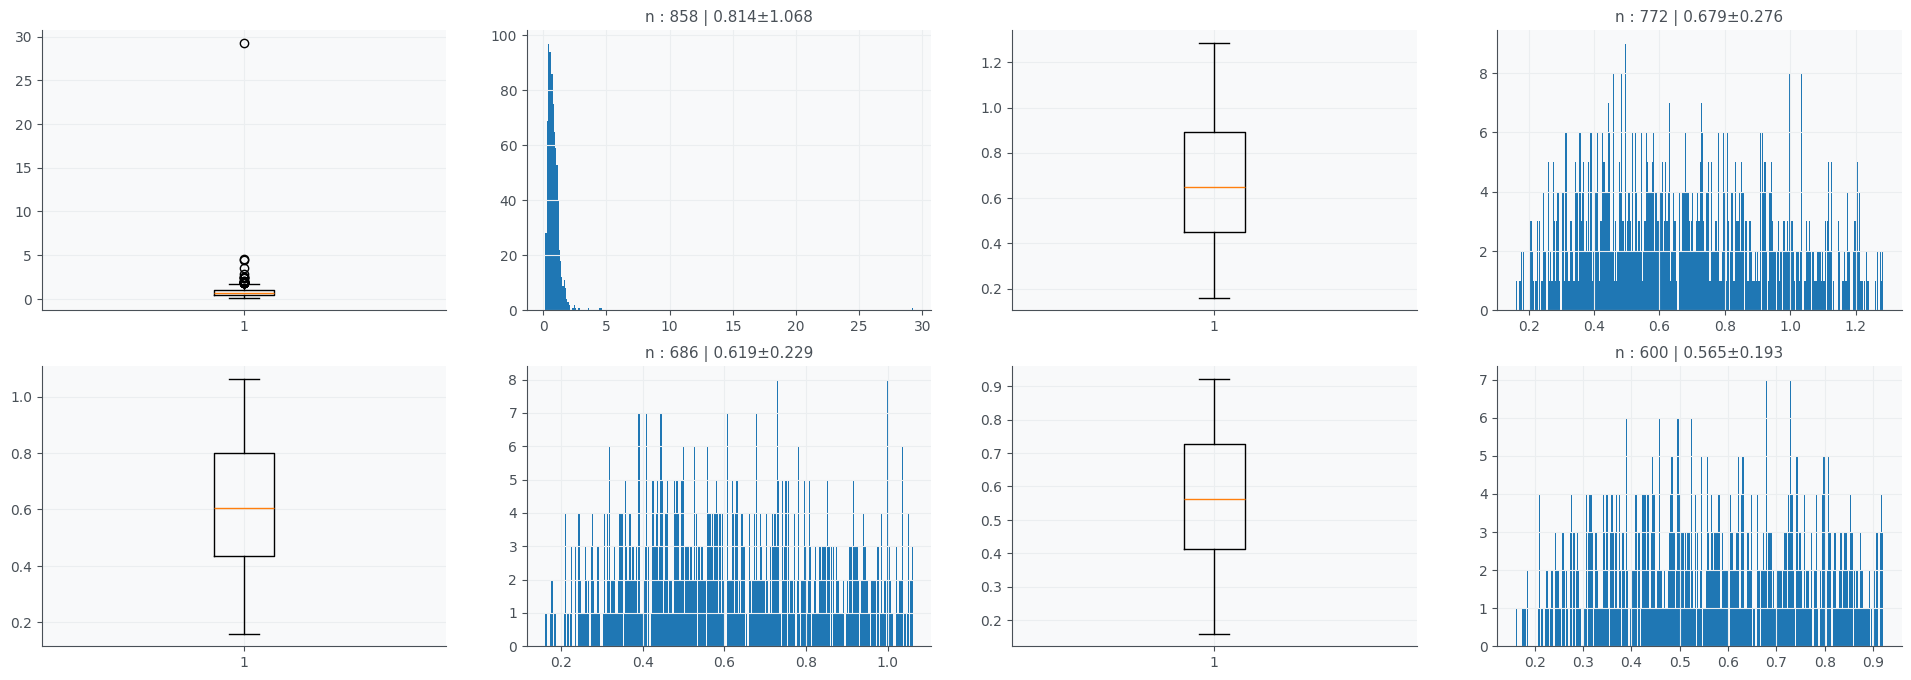

In [105]:
variable = 'SD1_SD2'
data = results[[variable]]

plt.figure(figsize = (24, 8))
plt.subplot(2, 4, 1)
plt.boxplot(data)
plt.subplot(2, 4, 2)
_ = plt.hist(data, bins = 300)
plt.title(f'n : {len(data)} | {round(data.mean().item(), 3)}±{round(data.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.90)[variable]]
plt.subplot(2, 4, 3)
plt.boxplot(cut)
plt.subplot(2, 4, 4)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.80)[variable]]
plt.subplot(2, 4, 5)
plt.boxplot(cut)
plt.subplot(2, 4, 6)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.70)[variable]]
plt.subplot(2, 4, 7)
plt.boxplot(cut)
plt.subplot(2, 4, 8)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)


Text(0.5, 1.0, 'n : 600 | 0.388±0.282')

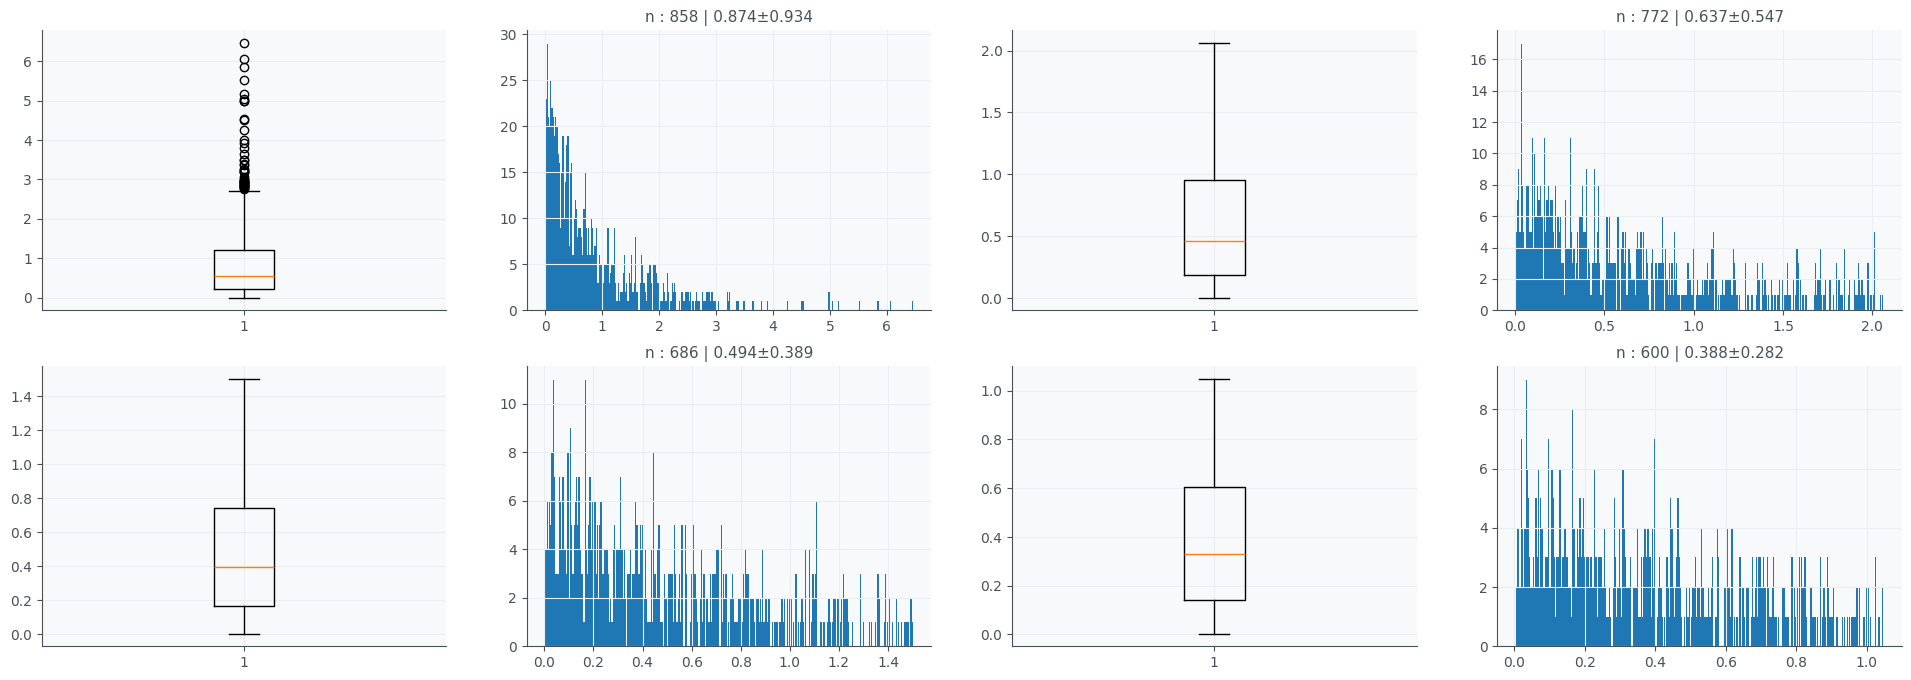

In [106]:
variable = 'LF_HF'
data = results[[variable]]

plt.figure(figsize = (24, 8))
plt.subplot(2, 4, 1)
plt.boxplot(data)
plt.subplot(2, 4, 2)
_ = plt.hist(data, bins = 300)
plt.title(f'n : {len(data)} | {round(data.mean().item(), 3)}±{round(data.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.90)[variable]]
plt.subplot(2, 4, 3)
plt.boxplot(cut)
plt.subplot(2, 4, 4)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.80)[variable]]
plt.subplot(2, 4, 5)
plt.boxplot(cut)
plt.subplot(2, 4, 6)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)

cut = data[data[variable] < data.quantile(0.70)[variable]]
plt.subplot(2, 4, 7)
plt.boxplot(cut)
plt.subplot(2, 4, 8)
_ = plt.hist(cut, bins = 300)
plt.title(f'n : {len(cut)} | {round(cut.mean().item(), 3)}±{round(cut.std().item(), 3)}',)
